# Finding Similar Songs on Spotify - Part 2: Siamese Networks

In the first part of this tutorial I have introduced the traditional distance based approach to similarity estimations. The main idea is that features are extracted from the audio content. These features are numeric descriptions of semantically relevant information. An example for a high-level feature is the number of beats per minute which is a description for the tempo of a song. Music feature-sets are more abstract and describe the spectral or rhythmical distribution of energy. These are not single but vectors of numbers. Thus, a song is semantically described by this vector and if the set of extracted features spans over various music characteristics such as rhythm, timbre, harmonics, complexity, etc. then calculating the similarity of the vector's numbers is considered to be an approximation of music similarity. Thus, the lower the numerical distance between two vectors, the higher their acoustic similarity. For this reason these approaches are known as *Distance based* methods. They mainly depend on the selected sets of features and on the similarity metric chosen to compare their values.

In the second part of this tutorial we are now focussing on an approach, where the feature representation, as well as the similarity function is learned from the underlying dataset.


## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

The requirements are the same as for the first part of the tutorials. Please follow the instructions of part one if you have trouble running this tutorial.

In [2]:
%load_ext autoreload

%autoreload 2

# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from IPython.display import IFrame

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

# spotify API
import spotipy
import spotipy.util as util

# local caching
from joblib import Memory

# functions from Tutorial Part 1
import tutorial_functions as tut_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Data

We will use the same data that we downloaded from Spotify in Part 1 of the Tutorial. Because we used the joblib library, we will not have to wait that long, because the data is already cached on our harddrive.

Update the following two variables according the credentials you received from Spotify

In [18]:
SPOTIFY_USER = "slychief"

os.environ["SPOTIPY_CLIENT_ID"]     = "8a7fffc37b6c44e6b7bc344c3295034c"
os.environ["SPOTIPY_CLIENT_SECRET"] = "f19dd914ba58408c9407dd6479b23812"

The same playlists as used in Part 1:

In [4]:
playlists = [
    
     {"name": "clubbeats",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DXbX3zSzB4MO0"},
     {"name": "softpop",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DWTwnEm1IYyoj"},
     {"name": "electropop",   "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4uPi2roRUwU"},
     {"name": "rockclassics", "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXRqgorJj26U"},
     {"name": "rockhymns",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4vth7idTQch"},
     {"name": "soft_rock",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX6xOPeSOGone"},
     {"name": "metalcore",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXIcbzpLauPS"}, 
     {"name": "metal",        "uri": "spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"},
     {"name": "classic_metal","uri": "spotify:user:spotify:playlist:37i9dQZF1DX2LTcinqsO68"},
     {"name": "grunge",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DX11ghcIxjcjE"},
     {"name": "hiphop",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DWVdgXTbYm2r0"},
     {"name": "poppunk",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXa9wYJr1oMFq"},
     {"name": "classic",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXcN1fAVSf7CR"}
    
]

Connect to the Spotify API

In [5]:
token = util.prompt_for_user_token("slychief", 
                                   "playlist-modify-public", 
                                   redirect_uri="http://localhost/")

sp = spotipy.Spotify(auth=token)

Create a temporary Spotify playlist to demonstrate results. Store playlist-ID for later processing

In [22]:
sp_response    = sp.user_playlist_create(SPOTIFY_USER, "tutorial_2", public=True)
sp_playlist_id = sp_response["id"]

Define the local chache directory. This should be the same as in Part 1 of the tutorial.

In [6]:
memory = Memory(cachedir='/home/schindler/tmp/spotify/', verbose=0)

Unfortunately I was not able to move this function to the tutorial_functions.py file, due to the @memory annotation. (If you know a way how to solve this, please create a Github-issue with your solution).

In [7]:
@memory.cache
def get_spotify_data(track_id):
    
    # meta-data
    track_metadata      = sp.track(track_id)
    album_metadata      = sp.album(track_metadata["album"]["id"])
    artist_metadata     = sp.artist(track_metadata["artists"][0]["id"])
    
    # feature-data
    sequential_features = sp.audio_analysis(track_id)
    trackbased_features = sp.audio_features([track_id])
    
    return track_metadata, album_metadata, artist_metadata, sequential_features, trackbased_features

Start loading the Spotify Data

In [8]:
# Get Playlist meta-data
playlists = tut_func.get_playlist_metadata(sp, playlists)

# Get track-ids of all playlist entries
playlists = tut_func.get_track_ids(sp, playlists)

num_tracks_total = np.sum([playlist["num_tracks"] for playlist in playlists])

# Fetch data and features from Spotify
pbar = progressbar.ProgressBar(max_value=num_tracks_total)
pbar.start()

raw_track_data      = []
processed_track_ids = []

for playlist in playlists:

    for track_id in playlist["track_ids"]:

        try:
            # avoid duplicates in the data-set
            if track_id not in processed_track_ids:

                # retrieve data from Spotify
                spotify_data = get_spotify_data(track_id)

                raw_track_data.append([playlist["name"], spotify_data])
                processed_track_ids.append(track_id)

        except Exception as e:
            print e

        pbar.update(len(raw_track_data))

 97% (963 of 987) |#################################################################################################################################################################################     | Elapsed Time: 0:00:41 ETA: 0:00:01

### Aggregate feature-data

Currently we only have a list of raw data-objects retrieved from the Spotify API. We need to transform this information to a more structured format.

In [9]:
# Aggregate Meta-data
metadata = tut_func.aggregate_metadata(raw_track_data)

# Aggregate Feature-data
feature_data = tut_func.aggregate_featuredata(raw_track_data, metadata)

# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

# Siamese Networks

A Siamese neural network is a neural network architecture where two inputs are fed into the same stack of network layers. This is where the name comes from. The shared layers are "similar" to Siamese Twins. By feeding two inputs to the shared layers, two representations are generated which can be used for comparison. To train the network according a certain task, it requires labelled data. To learn a simlarity function, these labels should indicate if the two input are similar or dissimilar.

This is exactly the approach initially described by Hadsell-et-al.'06 (http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf). The authors create pairs of simlar and dissimilar images. These are fed into a Siamese NEtwork stack. Finally, the model calculates the eucledian distance between the two generated representations. A contrastive loss is used, to optimize the learned simlarity.

To calculate the similarity between a seed image and the rest of the collection, the model is applied to predict the distance between this seed image and every other. The result is a list of distances which has to be sorted descendingly.

The following code example follows this approach:

**Keras**

We use the high-level deep learning API Keras. [TODO: link]

[TODO: describe - auf Tom's Tutorial verweisen für instructoins]

In [10]:
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.optimizers import Nadam, SGD
from keras.regularizers import l2, l1
from keras import backend as K
from keras.layers.merge import concatenate

First we define a distance measure to compare the two representations. We will be using the well known Eucledian distance:

In [11]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

### The Siamese Network Architecture

Now we define the Siamese Network Architecture. It consists of two fully connected layers. These layers are shared among the "Siamese twins". The network takes two inputs. One goes to the left twin, the other to the right one. The Eucledian distance of the output of each twin is calculated which is the final output of the model.

In [12]:
def create_siamese_network(input_dim):

    # input layers
    input_left  = Input(shape=input_dim)
    input_right = Input(shape=input_dim)

    # shared fully connected layers
    shared_fc_1 = Dense(100, activation="selu")
    shared_fc_2 = Dense(100, activation="selu")    
    
    # siamese layers
    left_twin  = shared_fc_1(shared_fc_2(input_left))
    right_twin = shared_fc_1(shared_fc_2(input_right))

    # calc difference
    distance = Lambda(euclidean_distance,
                      output_shape=lambda x: x[0])([left_twin, right_twin])

    return Model([input_left, input_right], distance)

**Contrastive Loss**

The contrastive loss is based on the Euclidean distance and measures the cost of data pairs. The objective of the contrastive loss is to minimize the distance between a similar pair and to separate any two dissimilar data with a distance margin

In [13]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Create Data-Pairs

Now we have to prepare and partition the input data. Because it is a pair-wise comparison approach, we have to create pairs of input instances. Especially, we will create sequences of genuine or similar pairs followed by impostor or dissimilar pairs.

In [14]:
def create_pairs(feature_data, metadata, num_pairs_per_track):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            
            # genuine pair
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            labels.append(1)

            # impostor pair
            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            labels.append(0)

    return np.array(data_pairs), np.array(labels)

Exectue the function to prepare the input data

In [15]:
# create pairs
data_pairs, labels = create_pairs(feature_data, metadata, 10)

# check - how many instances have we created?
data_pairs.shape

(19260, 2, 69)

Prepare the Siamese Neural Network

In [16]:
# define the model
model_orig = create_siamese_network(data_pairs[:,0].shape[1:])

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_orig.compile(loss      = contrastive_loss, 
                   optimizer = opt)

Train the network

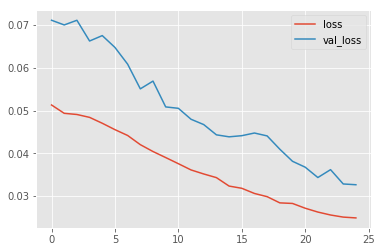

In [29]:
model_orig.fit([data_pairs[:, 0], data_pairs[:, 1]], 
                labels, 
                batch_size       = 24, 
                verbose          = 0, 
                epochs           = 25, 
                callbacks        = [tut_func.PlotLosses()], 
                validation_split = 0.1);

# Evaluate

Now that we have a trained model, we want to evaluate its performance. We will first play around with some examples, listen to the results and judge by our subjective interpretation before we persue a general evaluation.

### Evaluate by Example

The following function calculated the distances between a given query track and all other tracks of the collection. The result is a list of distances where the smallest distance coresponds with the most similar track. The list is sorted descendingly and the top-ten similar tracks are presented below the information of the query track. The Spotify playlist we created at the beginning will also be updated with the query results. Thus, you can listen to it in your Spotify client.

In [30]:
def similar(model, query_idx):
    
    print metadata.iloc[query_idx]
    
    # calclulate predicted distances between query track and all others
    res = [model.predict([feature_data[[query_idx]], feature_data[[i]]]) for i in range(feature_data.shape[0])]

    # reshape
    res = np.array(res)
    res = res.reshape(res.shape[0])

    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # update spotify playlist
    sp.user_playlist_replace_tracks(SPOTIFY_USER, sp_playlist_id, metadata.loc[si, "track_id"][:10])
    
    # output filter
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [31]:
similar(model_orig, 349)

track_id                                  3UDmHZcBTQp8Iu8droNtUl
artist_name                                          The Beatles
title                                    Revolution - Remastered
album_name                  The Beatles 1967 - 1970 (Remastered)
label                                              EMI Catalogue
duration                                                  205293
popularity                                                    59
year                                                        1973
genres         [british invasion, classic rock, merseybeat, p...
playlist                                            rockclassics
Name: 349, dtype: object


,artist_name,title,album_name,year,playlist
349,The Beatles,Revolution - Remastered,The Beatles 1967 - 1970 (Remastered),1973,rockclassics
405,Don McLean,American Pie,American Pie,1971,rockclassics
376,Steppenwolf,Born To Be Wild,Steppenwolf,1968,rockclassics
333,Rush,Tom Sawyer,Moving Pictures (2011 Remaster),1981,rockclassics
292,Bob Seger,Turn The Page - Live In Detroit/1975,'Live' Bullet,1976,rockclassics
307,The Who,Who Are You,Who Are You (Remastered),1978,rockclassics
334,Jimi Hendrix,All Along the Watchtower,Electric Ladyland,1968,rockclassics
406,The Doors,Riders On The Storm,L.A. Woman,1971,rockclassics
365,Blue Öyster Cult,(Don't Fear) The Reaper,Agents of Fortune,1976,rockclassics
398,Def Leppard,Pour Some Sugar On Me (2012),Pour Some Sugar On Me (2012),1987,rockclassics


### General Evaluation

So far we have only tested our similarity retrieval algorithms on a few single examples. To evaluate, if the presented approaches perform differently, we perform a full evaluation. To estimate the performance we measure precision and recall of our algorithms. These are standard information retrieval measures of relevance. In the context of this tutorial **precision** measures how many tracks of a given resultlist belong to the same playlist as the query song (relative to the length of the resultlist). **Recall** measures how many tracks of the query song's playlist are contained in the resultlist (relative to the length of the playlist).

In [53]:
def evaluate(similarity_function, cut_off):

    all_precisions = []
    all_recall     = []

    for idx in metadata.index.values:

        dist           = similarity_function(feature_data, feature_data[[idx]])
        dist           = np.array(dist).reshape(len(dist))
        similar_tracks = metadata.loc[np.argsort(dist)[:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

        recall = float(same_label.sum()) / metadata[metadata.playlist == metadata.loc[idx, "playlist"]].shape[0]
        all_recall.append(recall)

    all_precisions = np.array(all_precisions)
    all_recall     = np.array(recall)

    print "Precision", all_precisions.mean()
    print "Recall:",   all_recall.mean()

Run the evauation for the trained Siamese Network:

In [52]:
evaluate(lambda x,y: [model_orig.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

(0.96863966770508825, 0.40000000000000002)

# Improve Performance through prior Knowledge

The original approach only uses genuine and impostor pairs and does not consider any further prior knowledge. In that sense if two tracks belong to the same playlist, they are considered similar, if not, than they are not. But, because we have chosen genre-playlists, there are genres that are more similar than others. This is of course highly subjective and depends on the listening behaviour and experience of a listener.

The following list represents my own interpretation of genre similarities:

In [57]:
sim = [[["clubbeats",     "electropop"],    0.8],
       [["clubbeats",     "softpop"],       0.4],
       [["electropop",    "hiphop"],        0.4],
       [["softpop",       "soft_rock"],     0.2],
       [["softpop",       "electropop"],    0.4],
       [["softpop",       "hiphop"],        0.1],
       [["rockclassics",  "rockhymns"],     0.7],
       [["soft_rock",     "rockclassics"],  0.3],
       [["soft_rock",     "rockhymns"],     0.3],
       [["metalcore",     "metal"],         0.7],
       [["metalcore",     "classic_metal"], 0.6],
       [["metal",         "classic_metal"], 0.8],
       [["classic_metal", "grunge"],        0.5],
       [["metal",         "grunge"],        0.5],
       [["rockhymns",     "grunge"],        0.2],
       [["poppunk",       "metal"],         0.6],
       [["poppunk",       "classic_metal"], 0.4],
       [["poppunk",       "rockhymns"],     0.5],
       [["poppunk",       "rockclassics"],  0.4]]

The following code creates a symmetric lookup-table from the list above:

In [59]:
# get all playlist-names from our dataset
playlist_names = [pl["name"] for pl in playlists]

# create the lookup-table
playlist_similarities = pd.DataFrame(np.zeros((len(playlist_names),len(playlist_names))), 
                                     index   = playlist_names, 
                                     columns = playlist_names)

# self-similarity
for i in range(len(playlist_names)):
    for j in range(len(playlist_names)):
        if i == j:
            playlist_similarities.iloc[i,j] = 1.0

# genre-similarities
for s in sim:
    playlist_similarities.loc[s[0][0],s[0][1]] = s[1]
    playlist_similarities.loc[s[0][1],s[0][0]] = s[1]

# show results
playlist_similarities

,clubbeats,softpop,electropop,rockclassics,rockhymns,soft_rock,metalcore,metal,classic_metal,grunge,hiphop,poppunk,classic
clubbeats,1.0,0.4,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
softpop,0.4,1.0,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.1,0.0,0.0
electropop,0.8,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0
rockclassics,0.0,0.0,0.0,1.0,0.7,0.3,0.0,0.0,0.0,0.0,0.0,0.4,0.0
rockhymns,0.0,0.0,0.0,0.7,1.0,0.3,0.0,0.0,0.0,0.2,0.0,0.5,0.0
soft_rock,0.0,0.2,0.0,0.3,0.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
metalcore,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,0.6,0.0,0.0,0.0,0.0
metal,0.0,0.0,0.0,0.0,0.0,0.0,0.7,1.0,0.8,0.5,0.0,0.6,0.0
classic_metal,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.8,1.0,0.5,0.0,0.4,0.0
grunge,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.5,0.5,1.0,0.0,0.0,0.0


### Train network with prior knowledge

With this lookup-table we can create more accurate input pairs. Insted of similar/dissimilar we can now apply the supplied similarites:

In [60]:
def create_pairs_with_sims(feature_data, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            
            # similar
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, pos_example.playlist])

            # dissimilar
            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, neg_example.playlist])

    return np.array(data_pairs), np.array(labels)

Execute the function to prepare the data:

In [62]:
# get pairs
data_pairs, labels = create_pairs_with_sims(feature_data, metadata, 10, playlist_similarities)

# check - how many instances have we created?
data_pairs.shape

(19260, 2, 69)

In [66]:
# define the model
model_sim = create_siamese_network(data_pairs[:,0].shape[1:])

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_sim.compile(loss      = contrastive_loss, 
                  optimizer = opt)

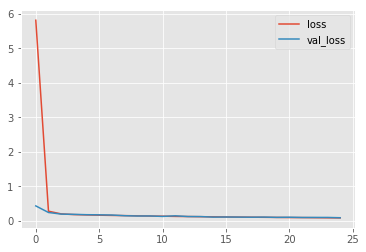

In [67]:
model_sim.fit([data_pairs[:, 0], data_pairs[:, 1]], 
               labels, 
               batch_size       = 24, 
               verbose          = 0, 
               epochs           = 25, 
               callbacks        = [tut_func.PlotLosses()], 
               validation_split = 0.1);

In [73]:
similar(model_sim, 349)

track_id                                  3UDmHZcBTQp8Iu8droNtUl
artist_name                                          The Beatles
title                                    Revolution - Remastered
album_name                  The Beatles 1967 - 1970 (Remastered)
label                                              EMI Catalogue
duration                                                  205293
popularity                                                    59
year                                                        1973
genres         [british invasion, classic rock, merseybeat, p...
playlist                                            rockclassics
Name: 349, dtype: object


,artist_name,title,album_name,year,playlist
349,The Beatles,Revolution - Remastered,The Beatles 1967 - 1970 (Remastered),1973,rockclassics
391,Bob Dylan,Like a Rolling Stone - Live from London 5/26/66,The Real Royal Albert Hall 1966 Concert (Live),1966,rockclassics
291,Eagles,Life In The Fast Lane,Hotel California (Remastered),1976,rockclassics
295,Steve Miller Band,Fly Like An Eagle,Fly Like An Eagle,1976,rockclassics
304,Bob Seger,Old Time Rock & Roll,Stranger In Town,1978,rockclassics
298,The Kinks,All Day and All of the Night,Kinks (Deluxe Edition),1964,rockclassics
300,The Who,Won't Get Fooled Again - Original Album Version,Who's Next (Deluxe Edition),1971,rockclassics
321,Led Zeppelin,Whole Lotta Love,Led Zeppelin II,1969,rockclassics
390,The Rolling Stones,Gimme Shelter,Let It Bleed,1969,rockclassics
323,David Bowie,The Jean Genie - 2013 Remastered Version,Aladdin Sane (40th Anniversary),1973,rockclassics


In [ ]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

In [75]:
def create_pairs_with_sims_and_identity(feature_data, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        data_pairs.append([feature_data[[row_id]][0], feature_data[[row_id]][0]])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            sim_val = playlist_similarities.loc[q_track.playlist, pos_example.playlist] - 0.1
            labels.append(np.max([0, sim_val]))

            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            sim_val = playlist_similarities.loc[q_track.playlist, neg_example.playlist] - 0.1
            labels.append(np.max([0, sim_val]))

    return np.array(data_pairs), np.array(labels)

In [76]:
data_pairs, labels = create_pairs_with_sims_and_identity(feature_data, metadata, 10, playlist_similarities)

In [77]:
# define the model
model_sim_id = create_siamese_network(data_pairs[:,0].shape[1:])

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_sim_id.compile(loss      = contrastive_loss, 
                  optimizer = opt)

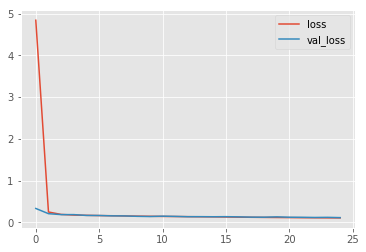

In [78]:
model_sim_id.fit([data_pairs[:, 0], data_pairs[:, 1]], 
               labels, 
               batch_size       = 24, 
               verbose          = 0, 
               epochs           = 25, 
               callbacks        = [tut_func.PlotLosses()], 
               validation_split = 0.1);

In [81]:
similar(model_sim_id, 739)

track_id                                  4eZDMbQm12jmaTFT6fOBwo
artist_name                                        Black Sabbath
title                                                   War Pigs
album_name                                 Paranoid (Remastered)
label                                                  Sanctuary
duration                                                  474400
popularity                                                    13
year                                                        1970
genres         [album rock, alternative rock, classic rock, h...
playlist                                           classic_metal
Name: 739, dtype: object


,artist_name,title,album_name,year,playlist
739,Black Sabbath,War Pigs,Paranoid (Remastered),1970,classic_metal
713,AC/DC,You Shook Me All Night Long,Back In Black,1980,classic_metal
807,Mother Love Bone,Crown Of Thorns,Mother Love Bone,1992,grunge
324,Jimi Hendrix,Hey Joe,Are You Experienced,1967,rockclassics
801,Love Battery,Between The Eyes,Between The Eyes,1992,grunge
299,Black Sabbath,Iron Man - Remastered Version,Paranoid (Remastered Edition),1970,rockclassics
800,L7,Pretend We're Dead,Bricks Are Heavy,1992,grunge
744,Anvil,Metal On Metal,Metal On Metal,1982,classic_metal
718,Judas Priest,Living After Midnight,British Steel,1980,classic_metal
365,Blue Öyster Cult,(Don't Fear) The Reaper,Agents of Fortune,1976,rockclassics


In [ ]:
model = create_siamese_network(data_pairs[:,0].shape[1:])

# train
rms = Nadam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])

In [ ]:
model.fit([data_pairs[:, 0], data_pairs[:, 1]], 
          labels, 
          batch_size       = 24, 
          verbose          = 0, 
          epochs           = 25, 
          callbacks        = [tut_func.PlotLosses()], 
          validation_split = 0.1)

In [ ]:
similar(761, ascending=True)

In [ ]:
evaluate(lambda x,y: [model.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

In [ ]:
def aggregate_features_sequential(seq_data, track_data, len_segment, m_data, with_year=False, with_popularity=False):
    
    # sequential data
    segments = seq_data["segments"]
    sl       = len(segments)
    
    mfcc              = np.array([s["timbre"]            for s in segments])
    chroma            = np.array([s["pitches"]           for s in segments])
    loudness_max      = np.array([s["loudness_max"]      for s in segments]).reshape((sl,1))
    loudness_start    = np.array([s["loudness_start"]    for s in segments]).reshape((sl,1))
    loudness_max_time = np.array([s["loudness_max_time"] for s in segments]).reshape((sl,1))
    duration          = np.array([s["duration"]          for s in segments]).reshape((sl,1))
    confidence        = np.array([s["confidence"]        for s in segments]).reshape((sl,1))
    
    # concatenate sequential features
    sequential_features = np.concatenate([mfcc, chroma, loudness_max, loudness_start, 
                                          loudness_max_time, duration, confidence], axis=1)
    
    offset  = np.random.randint(0, sl - len_segment)
    segment = sequential_features[offset:(offset+len_segment),:]
        
    # track-based data
    track_features = [track_data[0]["acousticness"],     # acoustic or not?
                      track_data[0]["danceability"],     # danceable?
                      track_data[0]["energy"],           # energetic or calm?
                      track_data[0]["instrumentalness"], # is somebody singing?
                      track_data[0]["liveness"],         # live or studio?
                      track_data[0]["speechiness"],      # rap or singing?
                      track_data[0]["tempo"],            # slow or fast?
                      track_data[0]["time_signature"],   # 3/4, 4/4, 6/8, etc.
                      track_data[0]["valence"]]          # happy or sad?
    
    if with_year:
        track_features.append(int(m_data["year"]))
        
    if with_popularity:
        track_features.append(int(m_data["popularity"]))
        
    
    return segment, track_features


In [ ]:
len_segment = 20

sequential_features = []
trackbased_features = []

for i, (_, spotify_data) in enumerate(raw_track_data):
    
    _, _, _, f_sequential, f_trackbased = spotify_data
    
    seq_feat, track_feat = aggregate_features_sequential(f_sequential, 
                                                         f_trackbased, 
                                                         len_segment, 
                                                         metadata.loc[i],
                                                         with_year=True,
                                                         with_popularity=True)
    
    sequential_features.append(seq_feat)
    trackbased_features.append(track_feat)
    
sequential_features = np.asarray(sequential_features)
trackbased_features = np.asarray(trackbased_features)

print "sequential_features.shape:", sequential_features.shape
print "trackbased_features.shape:", trackbased_features.shape

In [ ]:
# standardize sequential_features
rows, x, y = sequential_features.shape
sequential_features = sequential_features.reshape(rows, (x * y))
sequential_features -= sequential_features.mean(axis=0)
sequential_features /= sequential_features.std(axis=0)
sequential_features = sequential_features.reshape(rows, x, y)

In [ ]:
# standardize trackbased_features
trackbased_features -= trackbased_features.mean(axis=0)
trackbased_features /= trackbased_features.std(axis=0)

In [ ]:
def create_pairs_with_sims_and_identity_segments(sequential_features, trackbased_features, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs_seq   = []
    data_pairs_track = []
    labels           = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        data_pairs_seq.append([sequential_features[[row_id]][0], sequential_features[[row_id]][0]])
        data_pairs_track.append([trackbased_features[[row_id]][0], trackbased_features[[row_id]][0]])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs_seq.append([sequential_features[[row_id]][0], sequential_features[[pos_example.index]][0]])
            data_pairs_track.append([trackbased_features[[row_id]][0], trackbased_features[[pos_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, pos_example.playlist] - 0.1)

            data_pairs_seq.append([sequential_features[[row_id]][0], sequential_features[[neg_example.index]][0]])
            data_pairs_track.append([trackbased_features[[row_id]][0], trackbased_features[[neg_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, neg_example.playlist] - 0.1)

    return np.array(data_pairs_seq), np.array(data_pairs_track), np.asarray(labels)

In [ ]:
data_pairs_seq, data_pairs_track, labels = create_pairs_with_sims_and_identity_segments(sequential_features,
                                                                                        trackbased_features,
                                                                                        metadata, 
                                                                                        10, 
                                                                                        playlist_similarities)

In [ ]:
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, Input, Lambda
import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda,Convolution1D
from keras.optimizers import RMSprop, Nadam, SGD
from keras.regularizers import l2, l1
from keras import backend as K
#from keras.constraint import unit_norm
from keras.layers.merge import concatenate

In [ ]:
input_dim = data_pairs_seq[:, 0].shape[1:]

input_a = Input(shape=data_pairs_seq[:, 0].shape[1:])
input_b = Input(shape=data_pairs_seq[:, 0].shape[1:])
input_a2 = Input(shape=data_pairs_track[:, 0].shape[1:])
input_b2 = Input(shape=data_pairs_track[:, 0].shape[1:])

bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

processed_a = bdlstm(input_a)
processed_b = bdlstm(input_b)

dens = Dense(9, activation="selu")

processed_a2 = dens(input_a2)
processed_b2 = dens(input_b2)

left = concatenate([processed_a, processed_a2], axis=1)
right = concatenate([processed_b, processed_b2], axis=1)

L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance,
                  output_shape=lambda x: x[0])([left, right])

prediction = Dense(29 + 9, activation="elu")(distance)
#prediction = Dense(64, activation="elu")(prediction)

prediction = Dense(1, activation="sigmoid")(prediction)

model_rnn_mse = Model([input_a, input_b, input_a2, input_b2], prediction)

# train
rms = Nadam(lr=0.001)
model_rnn_mse.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])
#model_rnn_cl.compile(loss=contrastive_loss, optimizer=rms, metrics=["mean_squared_error", "accuracy"])

In [ ]:
model_rnn_mse.fit([data_pairs_seq[:, 0], data_pairs_seq[:, 1], data_pairs_track[:,0], data_pairs_track[:,1]], 
                  labels, 
                  batch_size       = 24, 
                  verbose          = 0, 
                  epochs           = 25,
                  callbacks        = [tut_func.PlotLosses()], 
                  validation_split = 0.1)

In [ ]:
def similar_rnn(model, query_idx, ascending=False):
    
    print metadata.iloc[query_idx]
        
    res = [model.predict([sequential_features[[query_idx]], sequential_features[[i]], trackbased_features[[query_idx]], trackbased_features[[i]]]) for i in range(feature_data.shape[0])]

    res = np.array(res)
    res = res.reshape(res.shape[0])

    if ascending:
        si = np.argsort(res)[::-1]
    else:
        si = np.argsort(res)
    
    sp.user_playlist_replace_tracks("slychief", "0FSLWht5SiNQMVPt3tBOIR", metadata.loc[si, "track_id"][:10])
    
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

In [ ]:
similar_rnn(model_rnn_mse, 349, ascending=False)

In [ ]:
similar_rnn(model_rnn_mse, 349, ascending=False)

In [ ]:
def evaluate(similarity_function, cut_off):

    all_precisions = []
    
    pbar = progressbar.ProgressBar()

    for idx in pbar(metadata.index.values):

        dist           = similarity_function(sequential_features, sequential_features[[idx]], trackbased_features, trackbased_features[[idx]])
        dist           = np.array(dist).reshape(len(dist))
        similar_tracks = metadata.loc[np.argsort(dist)[::-1][:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

    all_precisions = np.array(all_precisions)

    return all_precisions.mean()

In [ ]:
evaluate(lambda w,x,y,z: [model.predict([w[[i]],x,y[[i]],z]) for i in range(sequential_features.shape[0])], 20)